In [47]:
%matplotlib inline
from sklearn import model_selection, utils, metrics
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sn
import os
from PIL import Image
import numpy as np

In [2]:
# get list of image names
def get_list(dir_path):
    files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
    return files


In [3]:
# load image as numpy array
def load_img(img_path):
    img = Image.open(img_path)
    img = img.resize((200, 200))
    img = np.asarray(img, dtype=float)
    img = img/256
    img = np.moveaxis(img, -1, 0)
    return img
    
def label2num(x):
    if x == "dog":
        return 1
    return 0

In [4]:
train_path = "../../data/train"

In [5]:
images = get_list(train_path)

In [6]:
# split data into training and validation sets
x = images
y = [label2num(i.split(".")[0]) for i in images]
x, y = utils.shuffle(x, y)
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size = 0.25)
print(len(x_train))
print(len(x_val))

18750
6250


In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 3 x 200 x 200
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # 7 x 98 x 98
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # 2 x 47 x 47
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=4)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        # 48 x 22 x 22
        
        self.conv4 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        # 1 x 22 x 22
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=80, kernel_size=3)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2)
        # 80 x 4 x 4
        
        self.dense6 = nn.Linear(80 * 4 * 4, 1)
        # 1
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.dense6(x)
        x = torch.sigmoid(x)
        
        return x

In [8]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 3 x 200 x 200
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3 )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # 32 x 99 x 99
        
        self.dense2 = nn.Linear(32 * 99 * 99, 128)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(128, 1)
        # 1
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dense3(x)
        x = torch.sigmoid(x)
        
        return x

In [9]:
# Hyperparameters
LR = 5e-3
BATCH_SIZE = 128
EPOCHS = 20

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
model = Model2()
model.to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum=0.9)

In [12]:
# train
for epoch in range(EPOCHS):
    running_loss = 0.0
    loss_arr = []
    for i in range(0, len(x_train), BATCH_SIZE):
        optimizer.zero_grad()
        batch_x = [load_img(os.path.join(train_path, img)) for img in x_train[i: BATCH_SIZE+i]]
        batch_x = torch.from_numpy(np.array(batch_x))
        batch_x = batch_x.float()
        batch_x = batch_x.cuda()
        
        batch_y = [[y] for y in y_train[i: BATCH_SIZE+i]]
        batch_y = torch.from_numpy(np.array(batch_y))
        batch_y = batch_y.float()
        batch_y = batch_y.cuda()
        
        y_pred = model(batch_x)
#         print(y_pred, batch_y)
        
        loss = loss_fn(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_arr.append(loss.item())
        print(i, loss.item())


0 0.6918334364891052
128 0.6933972835540771
256 0.7043191194534302
384 0.7113128900527954
512 0.6965793371200562
640 0.6895521283149719
768 0.7035732269287109
896 0.6946576833724976
1024 0.7168532609939575
1152 0.6910800933837891
1280 0.6983333826065063
1408 0.685552716255188
1536 0.6879286766052246
1664 0.6799890995025635
1792 0.6685582995414734
1920 0.6929687261581421
2048 0.7078598737716675
2176 0.686393141746521
2304 0.695685625076294
2432 0.6935057044029236
2560 0.6671537160873413
2688 0.7084569931030273
2816 0.7480500936508179
2944 0.6776431202888489
3072 0.691460132598877
3200 0.71950364112854
3328 0.694129228591919
3456 0.6834338903427124
3584 0.680064857006073
3712 0.6931127905845642
3840 0.7012922763824463
3968 0.6872959136962891
4096 0.6762785911560059
4224 0.6826643943786621
4352 0.6892096996307373
4480 0.6896584033966064
4608 0.6867527365684509
4736 0.6775634288787842
4864 0.6790989637374878
4992 0.6832310557365417
5120 0.6717202663421631
5248 0.6807905435562134
5376 0.690

5760 0.6129395365715027
5888 0.5677204132080078
6016 0.6201200485229492
6144 0.6180907487869263
6272 0.577597975730896
6400 0.5442866086959839
6528 0.6560702323913574
6656 0.6055502891540527
6784 0.6002141833305359
6912 0.6462580561637878
7040 0.6189818978309631
7168 0.7561025619506836
7296 0.552273690700531
7424 0.5948617458343506
7552 0.6183397173881531
7680 0.5745029449462891
7808 0.6194282174110413
7936 0.5877211093902588
8064 0.5841459035873413
8192 0.5862371325492859
8320 0.5656753778457642
8448 0.6153090000152588
8576 0.6307246685028076
8704 0.6167348623275757
8832 0.601047933101654
8960 0.5948042869567871
9088 0.584328293800354
9216 0.5910738706588745
9344 0.5981813669204712
9472 0.5847795009613037
9600 0.5741895437240601
9728 0.6232254505157471
9856 0.6246328949928284
9984 0.5561437606811523
10112 0.5753597021102905
10240 0.5532695055007935
10368 0.6026993989944458
10496 0.6226626038551331
10624 0.6530608534812927
10752 0.5710808038711548
10880 0.5943484902381897
11008 0.62113

11392 0.5616778135299683
11520 0.5482238531112671
11648 0.5192400217056274
11776 0.4654651880264282
11904 0.5665607452392578
12032 0.5272407531738281
12160 0.4797931909561157
12288 0.5227600336074829
12416 0.6266595125198364
12544 0.6117501258850098
12672 0.6030560731887817
12800 0.5061805248260498
12928 0.5590425729751587
13056 0.5012595653533936
13184 0.6083096861839294
13312 0.5583999156951904
13440 0.5522414445877075
13568 0.46145182847976685
13696 0.6191890239715576
13824 0.5498355031013489
13952 0.5196675062179565
14080 0.5662969350814819
14208 0.6086578965187073
14336 0.5920188426971436
14464 0.5372092723846436
14592 0.5176311135292053
14720 0.5277019739151001
14848 0.562454104423523
14976 0.542498767375946
15104 0.4899602234363556
15232 0.49780577421188354
15360 0.6313512921333313
15488 0.5358724594116211
15616 0.5390800833702087
15744 0.6284593343734741
15872 0.4858449101448059
16000 0.5066857933998108
16128 0.5286928415298462
16256 0.5824722051620483
16384 0.4757228493690491


16512 0.4333445131778717
16640 0.39705806970596313
16768 0.45477378368377686
16896 0.47125184535980225
17024 0.42531099915504456
17152 0.44607803225517273
17280 0.44228237867355347
17408 0.43158650398254395
17536 0.4607154130935669
17664 0.4868294298648834
17792 0.3885370194911957
17920 0.4923400282859802
18048 0.3857530951499939
18176 0.3814108669757843
18304 0.4394252896308899
18432 0.49165624380111694
18560 0.3122948110103607
18688 0.4957422912120819
0 0.4244208335876465
128 0.5537976026535034
256 0.4827084541320801
384 0.37894925475120544
512 0.4647012948989868
640 0.385415643453598
768 0.48476266860961914
896 0.45570993423461914
1024 0.4135071635246277
1152 0.46344518661499023
1280 0.4222206473350525
1408 0.41127318143844604
1536 0.41608816385269165
1664 0.4592403173446655
1792 0.4819895029067993
1920 0.43263640999794006
2048 0.4204813241958618
2176 0.3820462226867676
2304 0.3965386748313904
2432 0.3834148347377777
2560 0.42634791135787964
2688 0.3876381814479828
2816 0.4731417596

2560 0.3110467791557312
2688 0.30329644680023193
2816 0.46916770935058594
2944 0.3383299708366394
3072 0.302351176738739
3200 0.35076969861984253
3328 0.4596458971500397
3456 0.38949906826019287
3584 0.36827367544174194
3712 0.4100429117679596
3840 0.339103639125824
3968 0.3190198838710785
4096 0.3130878210067749
4224 0.29051896929740906
4352 0.3871728181838989
4480 0.35430532693862915
4608 0.2860206365585327
4736 0.3385728597640991
4864 0.356769859790802
4992 0.33406955003738403
5120 0.29986751079559326
5248 0.3135302662849426
5376 0.3594093918800354
5504 0.35747426748275757
5632 0.32934868335723877
5760 0.36698755621910095
5888 0.2756296992301941
6016 0.401323527097702
6144 0.2446138858795166
6272 0.3983278274536133
6400 0.263621985912323
6528 0.34577494859695435
6656 0.366573691368103
6784 0.2674349844455719
6912 0.3701450228691101
7040 0.3593219220638275
7168 0.46073412895202637
7296 0.31354787945747375
7424 0.36464327573776245
7552 0.31085366010665894
7680 0.36230987310409546
7808

7296 0.21413639187812805
7424 0.28186118602752686
7552 0.3491799235343933
7680 0.24626177549362183
7808 0.2307722270488739
7936 0.2867387533187866
8064 0.22785329818725586
8192 0.22885848581790924
8320 0.23616880178451538
8448 0.22277593612670898
8576 0.2105141282081604
8704 0.3399811387062073
8832 0.20538052916526794
8960 0.1925082951784134
9088 0.38312315940856934
9216 0.26116523146629333
9344 0.21035446226596832
9472 0.34815192222595215
9600 0.2750362455844879
9728 0.21994158625602722
9856 0.30534595251083374
9984 0.24557733535766602
10112 0.24690021574497223
10240 0.21217161417007446
10368 0.21397840976715088
10496 0.3026026487350464
10624 0.23848982155323029
10752 0.2041608989238739
10880 0.22714866697788239
11008 0.32756930589675903
11136 0.3025861084461212
11264 0.24800212681293488
11392 0.2189890742301941
11520 0.3044910132884979
11648 0.35806021094322205
11776 0.23672720789909363
11904 0.2590246796607971
12032 0.3481197953224182
12160 0.3430277705192566
12288 0.258526980876922

11776 0.1341700702905655
11904 0.21466107666492462
12032 0.20018994808197021
12160 0.18985795974731445
12288 0.20038777589797974
12416 0.165563702583313
12544 0.2638985514640808
12672 0.22556984424591064
12800 0.1835169792175293
12928 0.16203367710113525
13056 0.18934564292430878
13184 0.21044722199440002
13312 0.16007587313652039
13440 0.13880109786987305
13568 0.1536269634962082
13696 0.15491646528244019
13824 0.21926957368850708
13952 0.14064984023571014
14080 0.16243310272693634
14208 0.17818719148635864
14336 0.183275043964386
14464 0.1544121950864792
14592 0.17131224274635315
14720 0.18181300163269043
14848 0.17787013947963715
14976 0.15894350409507751
15104 0.15915676951408386
15232 0.1700359731912613
15360 0.20599055290222168
15488 0.15176251530647278
15616 0.15663492679595947
15744 0.12314523011445999
15872 0.10327039659023285
16000 0.10047635436058044
16128 0.21201324462890625
16256 0.15902398526668549
16384 0.13592630624771118
16512 0.13150358200073242
16640 0.15553867816925

15872 0.27189040184020996
16000 0.2508559823036194
16128 0.19495321810245514
16256 0.1456957459449768
16384 0.12649312615394592
16512 0.1691151261329651
16640 0.19073757529258728
16768 0.1253071427345276
16896 0.17910216748714447
17024 0.13953611254692078
17152 0.1381669044494629
17280 0.11279415339231491
17408 0.25161635875701904
17536 0.19946686923503876
17664 0.15807746350765228
17792 0.13722564280033112
17920 0.19814454019069672
18048 0.19617614150047302
18176 0.2147468775510788
18304 0.0971783846616745
18432 0.14139646291732788
18560 0.20638276636600494
18688 0.15063141286373138
0 0.24146905541419983
128 0.18740804493427277
256 0.12614935636520386
384 0.21900121867656708
512 0.37640371918678284
640 0.1359981745481491
768 0.12263049185276031
896 0.14121560752391815
1024 0.17127487063407898
1152 0.25270581245422363
1280 0.16671842336654663
1408 0.10058273375034332
1536 0.11626650393009186
1664 0.23652370274066925
1792 0.21248376369476318
1920 0.15124548971652985
2048 0.0986432135105

1024 0.10092043876647949
1152 0.06413397192955017
1280 0.07376238703727722
1408 0.09464327991008759
1536 0.09331148862838745
1664 0.14187096059322357
1792 0.08007809519767761
1920 0.07397685199975967
2048 0.09812958538532257
2176 0.08837048709392548
2304 0.08994688838720322
2432 0.056762732565402985
2560 0.05998612195253372
2688 0.11696363985538483
2816 0.06463880091905594
2944 0.09303151071071625
3072 0.07274897396564484
3200 0.07445042580366135
3328 0.09344765543937683
3456 0.151844322681427
3584 0.12369700521230698
3712 0.08936471492052078
3840 0.07922899723052979
3968 0.18036727607250214
4096 0.11228610575199127
4224 0.057805273681879044
4352 0.06456036120653152
4480 0.08790505677461624
4608 0.06254014372825623
4736 0.10585696250200272
4864 0.13222837448120117
4992 0.09472520649433136
5120 0.07071536034345627
5248 0.05746345967054367
5376 0.07702813297510147
5504 0.10010816156864166
5632 0.08803188800811768
5760 0.09864544868469238
5888 0.08485248684883118
6016 0.07774775475263596


In [90]:
model.to("cpu")
torch.save(model.state_dict(), "../../weights/vgg1-weights.pt")
model.to(device)

Model2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense2): Linear(in_features=313632, out_features=128, bias=True)
  (relu2): ReLU()
  (dense3): Linear(in_features=128, out_features=1, bias=True)
)

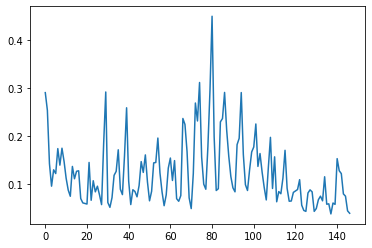

In [26]:
plt.plot([i for i in range(len(loss_arr))], loss_arr)

In [33]:
# testing
y_train_pred = []
with torch.no_grad():
    for i in range(0, len(x_train), BATCH_SIZE):
            batch_x = [load_img(os.path.join(train_path, img)) for img in x_train[i: BATCH_SIZE+i]]
            batch_x = torch.from_numpy(np.array(batch_x))
            batch_x = batch_x.float()
            batch_x = batch_x.cuda()

            y_pred = model(batch_x)
            y_pred = y_pred.cpu().numpy()
            y_train_pred += [1 if i > 0.5 else 0 for i in y_pred]

In [37]:
# testing
y_val_pred = []
with torch.no_grad():
    for i in range(0, len(x_val), BATCH_SIZE):
            batch_x = [load_img(os.path.join(train_path, img)) for img in x_val[i: BATCH_SIZE+i]]
            batch_x = torch.from_numpy(np.array(batch_x))
            batch_x = batch_x.float()
            batch_x = batch_x.cuda()

            y_pred = model(batch_x)
            y_pred = y_pred.cpu().numpy()
            y_val_pred += [1 if i > 0.5 else 0 for i in y_pred]

In [54]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

----------- Train ----------------
    Accuracy  : 0.90800
    Precision : 0.84527
    Recall    : 0.99850
    F1 Score  : 0.91552
    MCC       : 0.82975


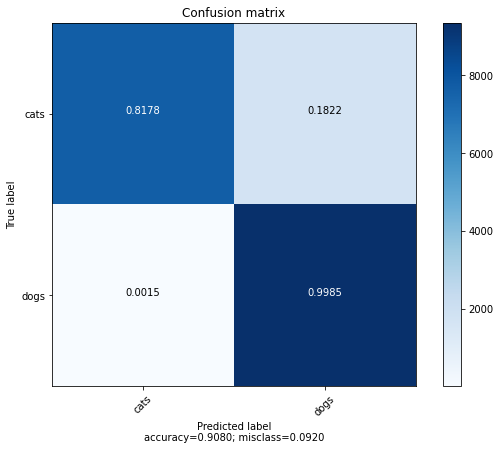

In [84]:
print("----------- Train ----------------")
print("    Accuracy  : %.5f" % (metrics.accuracy_score(y_train, y_train_pred)))
print("    Precision : %.5f" % metrics.precision_score(y_train, y_train_pred))
print("    Recall    : %.5f" % metrics.recall_score(y_train, y_train_pred))
print("    F1 Score  : %.5f" % metrics.f1_score(y_train, y_train_pred))
print("    MCC       : %.5f" % metrics.matthews_corrcoef(y_train, y_train_pred))
plot_confusion_matrix(metrics.confusion_matrix(y_train, y_train_pred), target_names=["cats", "dogs"])

----------- Validation ----------------
    Accuracy  : 0.67840
    Precision : 0.62879
    Recall    : 0.87799
    F1 Score  : 0.73278
    MCC       : 0.38781


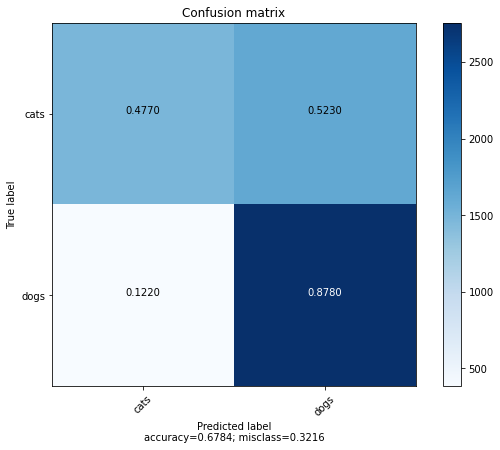

In [86]:
print("----------- Validation ----------------")
print("    Accuracy  : %.5f" % (metrics.accuracy_score(y_val, y_val_pred)))
print("    Precision : %.5f" % metrics.precision_score(y_val, y_val_pred))
print("    Recall    : %.5f" % metrics.recall_score(y_val, y_val_pred))
print("    F1 Score  : %.5f" % metrics.f1_score(y_val, y_val_pred))
print("    MCC       : %.5f" % metrics.matthews_corrcoef(y_val, y_val_pred))
plot_confusion_matrix(metrics.confusion_matrix(y_val, y_val_pred), target_names=["cats", "dogs"])